# OLS en Gradient Descent

In dit labo passen we verschillende methoden toe om lineaire regressie parameters te schatten:
1. De _closed form_ OLS oplossing
2. Vergelijking met scikit-learn, NumPy en statsmodels OLS implementaties
3. Gradient berekening met PyTorch autograd
4. Implementatie van Stochastic Gradient Descent

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import torch
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(67)
torch.manual_seed(67)

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

## Dataset [California Housing](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) 🌴

In [2]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame

print(f"Dataset shape: {df.shape}")
print(f"\nFeatures: {housing.feature_names}")
print("\nFirst rows:")
display(df.head())

print("\nBasic statistics:")
display(df.describe())

Dataset shape: (20640, 9)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

First rows:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Basic statistics:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## Design matrix

We werken met slechts twee predictor-variabelen:
1. `MedInc`: _median income in block group_
2. `AveRooms`: _average number of rooms per household_   
  
De target variabele is `MedHouseVal`: _median house value for California districts, expressed in hundreds of thousands of dollars ($100,000)_

## ✍️
Hoe ziet de algemene matrix vorm van het model eruit?

$$
\pmb{y} = \pmb{X}\pmb{b} + \pmb{e}
$$

## ✍️

Hoe ziet de parameter tensor er specifiek uit?

$$
\pmb{b} = \begin{bmatrix}
b_1 \cr
b_2 \cr
b_3 \cr
\end{bmatrix}
$$

## ✍️

Hoe die de design/feature matrix er specifiek uit?

$$
\pmb{X} = \begin{bmatrix}
1 & x_{1,1} & x_{1, 2} \cr
1 & x_{2,1} & x_{2, 2} \cr
\vdots & \vdots & \vdots \cr
1 & x_{n,1} & x_{n, 2} \cr
\end{bmatrix}
$$

## ✍️

Hoe implementeren we deze tensors in Python?

In [3]:
x1 = "MedInc"  # Median income
x2 = "AveRooms"  # Average number of rooms
target = "MedHouseVal"  # Median house value

# Create feature matrix (without bias yet)
X_features = df[[x1, x2]].values
y = df[target].values

# Add bias term (column of ones) to create design matrix
X = np.column_stack([np.ones(X_features.shape[0]), X_features])

print(f"Design matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nFirst 5 rows of design matrix (bias, {x1}, {x2}):")
print(X[:5])
print("\nFirst 5 target values:")
print(y[:5])

Design matrix X shape: (20640, 3)
Target vector y shape: (20640,)

First 5 rows of design matrix (bias, MedInc, AveRooms):
[[1.         8.3252     6.98412698]
 [1.         8.3014     6.23813708]
 [1.         7.2574     8.28813559]
 [1.         5.6431     5.8173516 ]
 [1.         3.8462     6.28185328]]

First 5 target values:
[4.526 3.585 3.521 3.413 3.422]


## _Standard Scaling_
$$
\begin{align}
\pmb{\overline{x}_i}^c &= \pmb{0} \cr
std(\pmb{x_i}) &= 1
\end{align}
$$

## ✍️

In [4]:
# Create scaler and fit on features (without bias column)
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Create design matrix with bias term
X_scaled = np.column_stack([np.ones(X_features_scaled.shape[0]), X_features_scaled])

# Scale target variable
y_mean = np.mean(y)
y_std = np.std(y)
y_scaled = (y - y_mean) / y_std

## Conditienummer en Correlatie

## ✍️
Hoe is het gesteld met het conditienummer van de design matrix en de multicollineariteit bij de predictoren?

In [5]:
# Calculate condition number
condition_number = np.linalg.cond(X_scaled)
print(f"Condition number of design matrix: {condition_number:.2f}")
print("\nInterpretation:")
if condition_number < 10:
    print("- Excellent: Matrix is well-conditioned")
elif condition_number < 100:
    print("- Good: Matrix is reasonably well-conditioned")
elif condition_number < 1000:
    print("- Fair: Some numerical instability may occur")
else:
    print("- Poor: Matrix is ill-conditioned, results may be unreliable")

Condition number of design matrix: 1.40

Interpretation:
- Excellent: Matrix is well-conditioned


Correlation matrix:


,MedInc,AveRooms,MedHouseVal
MedInc,1.000000,0.326895,0.688075
AveRooms,0.326895,1.000000,0.151948
MedHouseVal,0.688075,0.151948,1.000000


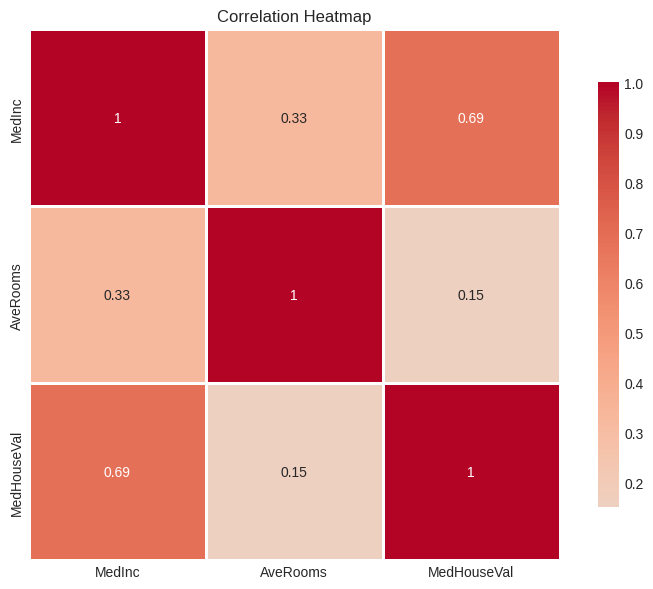


Correlation between MedInc and AveRooms: 0.3269
Multicollinearity assessment: Low


In [6]:
# Correlation analysis
correlation_data = pd.DataFrame(X_features_scaled, columns=[x1, x2])
correlation_data[target] = y_scaled

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

print("Correlation matrix:")
display(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Check multicollinearity
predictor_correlation = corr_matrix.loc[x1, x2]
print(f"\nCorrelation between {x1} and {x2}: {predictor_correlation:.4f}")
print(f"Multicollinearity assessment: {'Low' if abs(predictor_correlation) < 0.7 else 'High'}")

## Manuele OLS

## ✍️

Hoe implementeren we de analytische oplossing in Python?

$$
\hat{\pmb{b}} = (\pmb{X}^T\pmb{X})^{-1}\pmb{X}^T\pmb{y}
$$

In [7]:
def closed_form_ols(X, y):
    """
    Compute OLS coefficients using the closed-form solution.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Design matrix including bias term
    y : ndarray, shape (n_samples,)
        Target vector

    Returns
    -------
    beta : ndarray, shape (n_features,)
        Estimated coefficients
    """
    XtX = X.T @ X
    Xty = X.T @ y
    beta = np.linalg.inv(XtX) @ Xty
    return beta


# Calculate coefficients
beta_closed = closed_form_ols(X_scaled, y_scaled)

print("Closed-form OLS coefficients:")
print(f"  β₀ (bias):        {beta_closed[0]:.6f}")
print(f"  β₁ ({x1}):    {beta_closed[1]:.6f}")
print(f"  β₂ ({x2}): {beta_closed[2]:.6f}")

# Calculate predictions and metrics
y_pred_closed = X_scaled @ beta_closed
mse_closed = mean_squared_error(y_scaled, y_pred_closed)
r2_closed = r2_score(y_scaled, y_pred_closed)

print("\nModel performance:")
print(f"  MSE:  {mse_closed:.6f}")
print(f"  R²:   {r2_closed:.6f}")

Closed-form OLS coefficients:
  β₀ (bias):        0.000000
  β₁ (MedInc):    0.714787
  β₂ (AveRooms): -0.081712

Model performance:
  MSE:  0.520589
  R²:   0.479411


## Scikit-learn OLS

Hoe implementeren we OLS met scikit-learn?

In [8]:
# Scikit-learn LinearRegression
lr_sklearn = LinearRegression()
lr_sklearn.fit(X_features_scaled, y_scaled)

# Extract coefficients
beta_sklearn = np.array([lr_sklearn.intercept_, *lr_sklearn.coef_])

print("Scikit-learn OLS coefficients:")
print(f"  β₀ (bias):        {beta_sklearn[0]:.6f}")
print(f"  β₁ ({x1}):    {beta_sklearn[1]:.6f}")
print(f"  β₂ ({x2}): {beta_sklearn[2]:.6f}")

# Calculate metrics
y_pred_sklearn = lr_sklearn.predict(X_features_scaled)
mse_sklearn = mean_squared_error(y_scaled, y_pred_sklearn)
r2_sklearn = r2_score(y_scaled, y_pred_sklearn)

print("\nModel performance:")
print(f"  MSE:  {mse_sklearn:.6f}")
print(f"  R²:   {r2_sklearn:.6f}")

Scikit-learn OLS coefficients:
  β₀ (bias):        0.000000
  β₁ (MedInc):    0.714787
  β₂ (AveRooms): -0.081712

Model performance:
  MSE:  0.520589
  R²:   0.479411


## NumPy OLS

Hoe implementeren we OLS met NumPy[^numpy]?

[^numpy]: NumPy's lstsq gebruikt SVD (Singular Value Decomposition) wat numeriek stabieler is dan directe matrix inversie.

In [9]:
# NumPy least squares solution
beta_numpy, residuals, rank, s = np.linalg.lstsq(X_scaled, y_scaled, rcond=None)

print("NumPy lstsq OLS coefficients:")
print(f"  β₀ (bias):        {beta_numpy[0]:.6f}")
print(f"  β₁ ({x1}):    {beta_numpy[1]:.6f}")
print(f"  β₂ ({x2}): {beta_numpy[2]:.6f}")

# Calculate metrics
y_pred_numpy = X_scaled @ beta_numpy
mse_numpy = mean_squared_error(y_scaled, y_pred_numpy)
r2_numpy = r2_score(y_scaled, y_pred_numpy)

print("\nModel performance:")
print(f"  MSE:  {mse_numpy:.6f}")
print(f"  R²:   {r2_numpy:.6f}")
print("\nAdditional info:")
print(f"  Residual sum of squares: {residuals[0]:.6f}")
print(f"  Rank of design matrix: {rank}")

NumPy lstsq OLS coefficients:
  β₀ (bias):        0.000000
  β₁ (MedInc):    0.714787
  β₂ (AveRooms): -0.081712

Model performance:
  MSE:  0.520589
  R²:   0.479411

Additional info:
  Residual sum of squares: 10744.959552
  Rank of design matrix: 3


## Statsmodels OLS

Hoe implementeren we OLS met statsmodels?

In [10]:
# Statsmodels OLS
model_sm = sm.OLS(y_scaled, X_scaled)
results_sm = model_sm.fit()

# Extract coefficients
beta_statsmodels = results_sm.params

print("Statsmodels OLS coefficients:")
print(f"  β₀ (bias):        {beta_statsmodels[0]:.6f}")
print(f"  β₁ ({x1}):    {beta_statsmodels[1]:.6f}")
print(f"  β₂ ({x2}): {beta_statsmodels[2]:.6f}")

print("\nFull statistical summary:")
print(results_sm.summary())

Statsmodels OLS coefficients:
  β₀ (bias):        0.000000
  β₁ (MedInc):    0.714787
  β₂ (AveRooms): -0.081712

Full statistical summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     9502.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:18:07   Log-Likelihood:                -22550.
No. Observations:               20640   AIC:                         4.511e+04
Df Residuals:                   20637   BIC:                         4.513e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    

## Samenvatting

In [11]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(
    {
        "Closed-form": beta_closed,
        "Scikit-learn": beta_sklearn,
        "NumPy lstsq": beta_numpy,
        "Statsmodels": beta_statsmodels,
    },
    index=["β₀ (bias)", f"β₁ ({x1})", f"β₂ ({x2})"],
)

print("Coefficient comparison:")
display(comparison_df)

Coefficient comparison:


,Closed-form,Scikit-learn,NumPy lstsq,Statsmodels
β₀ (bias),2.128384e-16,1.619548e-16,1.916492e-16,4.753142e-16
β₁ (MedInc),7.147865e-01,7.147865e-01,7.147865e-01,7.147865e-01
β₂ (AveRooms),-8.171217e-02,-8.171217e-02,-8.171217e-02,-8.171217e-02


## Automatische differentiatie

PyTorch's automatische differentiatie `autograd` berekent gradiënten automatisch. De bibliotheek is voornamelijk bedoeld voor gebruik bij neurale netwerken, maar hier kunnen we er al een eerste keer gebruik van maken om _gradient descent_ te implementeren voor ons lineaire regressiemodel.

Hieronder eerst een demonstratie met een eenvoudig voorbeeld.

In [12]:
# Simple example: compute gradient of f(x) = x^2 + 3x + 5
print("Example: f(x) = x² + 3x + 5")
print("Analytical gradient: f'(x) = 2x + 3")

x = torch.tensor(2.0, requires_grad=True)
print(f"\nEvaluate at x = {x.item()}")

# Forward pass
f = x**2 + 3 * x + 5
print(f"f(x) = {f.item()}")

# Backward pass (compute gradient)
f.backward()
print(f"Computed gradient f'(x) = {x.grad.item()}")
print(f"Analytical gradient at x=2: 2(2) + 3 = {2 * 2 + 3}")

Example: f(x) = x² + 3x + 5
Analytical gradient: f'(x) = 2x + 3

Evaluate at x = 2.0
f(x) = 15.0
Computed gradient f'(x) = 7.0
Analytical gradient at x=2: 2(2) + 3 = 7


### Hoe werkt automatische differentiatie?

In het bovenstaande voorbeeld zien we hoe PyTorch de gradiënt automatisch berekent:

1. **Forward pass**: We definiëren de functie `f = x² + 3x + 5` en PyTorch houdt alle operaties bij in een _computational graph_.

2. **Backward pass**: Bij het aanroepen van `f.backward()` past PyTorch de som regel toe om de gradiënt te berekenen. Voor elke operatie in de graph kent PyTorch de afgeleide:
   - Afgeleide van x²: 2x
   - Afgeleide van 3x: 3
   - Afgeleide van constante: 0

3. **Resultaat**: De gradiënt wordt opgeslagen in `x.grad`. Bij x=2 vinden we f'(2) = 2(2) + 3 = 7.

Dit mechanisme is fundamenteel voor gradient descent: we kunnen complexe functies definiëren en PyTorch berekent automatisch de gradiënten die nodig zijn om de parameters te optimaliseren.

## ✍️

Hoe implementeren we automatische differentiatie voor:

$$
f(x, y) = x^2y + 3xy^2
$$

In [13]:
# Example with multiple variables
print("Example: f(x, y) = x²y + 3xy²")
print("∂f/∂x = 2xy + 3y²")
print("∂f/∂y = x² + 6xy")

x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)

print(f"\nEvaluate at x = {x.item()}, y = {y.item()}")

# Forward pass
f = x**2 * y + 3 * x * y**2
print(f"f(x, y) = {f.item()}")

# Backward pass
f.backward()
print("\nComputed gradients:")
print(f"  ∂f/∂x = {x.grad.item()}")
print(f"  ∂f/∂y = {y.grad.item()}")

print("\nAnalytical gradients at x=3, y=2:")
print(f"  ∂f/∂x = 2(3)(2) + 3(2)² = {2 * 3 * 2 + 3 * 2**2}")
print(f"  ∂f/∂y = (3)² + 6(3)(2) = {3**2 + 6 * 3 * 2}")

Example: f(x, y) = x²y + 3xy²
∂f/∂x = 2xy + 3y²
∂f/∂y = x² + 6xy

Evaluate at x = 3.0, y = 2.0
f(x, y) = 54.0

Computed gradients:
  ∂f/∂x = 24.0
  ∂f/∂y = 45.0

Analytical gradients at x=3, y=2:
  ∂f/∂x = 2(3)(2) + 3(2)² = 24
  ∂f/∂y = (3)² + 6(3)(2) = 45


## Gradient Descent met `autograd`

## ✍️

In [14]:
# Parameter vector with initial values (zeros work well for standardized data)
b = torch.tensor([0.0, 0.0, 0.0], requires_grad=True, dtype=torch.float32)
print(f"Initial parameters: {b}")

# Design matrix
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Target vector
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Training loop
n_iterations = 1000
learning_rate = 0.01
loss_history = []

for i in range(n_iterations):
    # Forward pass: compute predictions
    y_pred = X_tensor @ b

    # Compute loss (Mean Squared Error)
    loss = torch.mean((y_tensor - y_pred) ** 2)

    # Backward pass: compute gradients (autograd!)
    loss.backward()  # Compute gradients via backpropagation

    # Update parameters
    with torch.no_grad():  # Disable gradient tracking for parameter update
        b -= learning_rate * b.grad

    # Zero gradients for next iteration (crucial!)
    b.grad.zero_()

    # Store loss for visualization
    loss_history.append(loss.item())

    if (i + 1) % 100 == 0 or i == 0:
        print(f"Iteration {i + 1}/{n_iterations}, Loss: {loss.item():.6f}")

# Extract learned parameters
print("\nFinal parameters: {b}")
print("\nComparison with closed-form OLS:")
print(f"  β₀: GD={b[0].item():.6f}, OLS={beta_closed[0]:.6f}")
print(f"  β₁: GD={b[1].item():.6f}, OLS={beta_closed[1]:.6f}")
print(f"  β₂: GD={b[2].item():.6f}, OLS={beta_closed[2]:.6f}")

Initial parameters: tensor([0., 0., 0.], requires_grad=True)
Iteration 1/1000, Loss: 1.000000
Iteration 100/1000, Loss: 0.536470
Iteration 200/1000, Loss: 0.521565
Iteration 300/1000, Loss: 0.520654
Iteration 400/1000, Loss: 0.520593
Iteration 500/1000, Loss: 0.520589
Iteration 600/1000, Loss: 0.520589
Iteration 700/1000, Loss: 0.520589
Iteration 800/1000, Loss: 0.520589
Iteration 900/1000, Loss: 0.520589
Iteration 1000/1000, Loss: 0.520589

Final parameters: {b}

Comparison with closed-form OLS:
  β₀: GD=0.000000, OLS=0.000000
  β₁: GD=0.714785, OLS=0.714787
  β₂: GD=-0.081711, OLS=-0.081712


## Stochastic Gradient Descent

## 🎯

Mini-batch Stochastic Gradient Descent
Dataset size: 20640
Batch size: 256
Batches per epoch: 81
Number of epochs: 50

Epoch 1/50, Avg Loss: 0.669930
Epoch 10/50, Avg Loss: 0.522375
Epoch 10/50, Avg Loss: 0.522375
Epoch 20/50, Avg Loss: 0.521220
Epoch 20/50, Avg Loss: 0.521220
Epoch 30/50, Avg Loss: 0.520929
Epoch 30/50, Avg Loss: 0.520929
Epoch 40/50, Avg Loss: 0.520946
Epoch 40/50, Avg Loss: 0.520946
Epoch 50/50, Avg Loss: 0.521442

Training completed!

Final SGD parameters:
  β₀ (bias):        0.000466
  β₁ (MedInc):    0.711527
  β₂ (AveRooms): -0.072727

Comparison with other methods:
  β₀: SGD=0.000466, GD=0.000000, OLS=0.000000
  β₁: SGD=0.711527, GD=0.714785, OLS=0.714787
  β₂: SGD=-0.072727, GD=-0.081711, OLS=-0.081712
Epoch 50/50, Avg Loss: 0.521442

Training completed!

Final SGD parameters:
  β₀ (bias):        0.000466
  β₁ (MedInc):    0.711527
  β₂ (AveRooms): -0.072727

Comparison with other methods:
  β₀: SGD=0.000466, GD=0.000000, OLS=0.000000
  β₁: SGD=0.711527, GD=0.

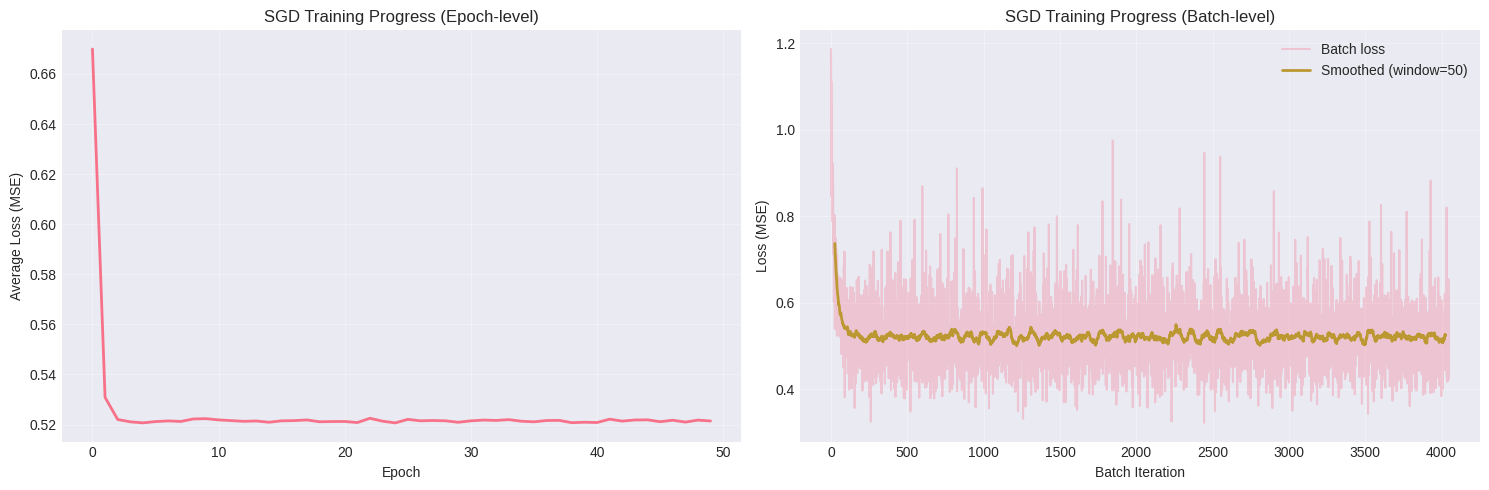


Final SGD model performance:
  MSE:  0.520662
  R²:   0.479338


In [ ]:
# Mini-batch Stochastic Gradient Descent
print("Mini-batch Stochastic Gradient Descent")
print("=" * 50)

# Hyperparameters
batch_size = 256
n_epochs = 50
learning_rate_sgd = 0.01

# Initialize parameters
b_sgd = torch.tensor([0.0, 0.0, 0.0], requires_grad=True, dtype=torch.float32)

# Convert data to tensors (already done, but for clarity)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

n_samples = X_tensor.shape[0]
n_batches = int(np.ceil(n_samples / batch_size))

print(f"Dataset size: {n_samples}")
print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {n_batches}")
print(f"Number of epochs: {n_epochs}\n")

# Training loop
loss_history_sgd = []
epoch_losses = []

for epoch in range(n_epochs):
    # Shuffle data at the start of each epoch
    indices = torch.randperm(n_samples)
    X_shuffled = X_tensor[indices]
    y_shuffled = y_tensor[indices]

    epoch_loss = 0.0

    # Process mini-batches
    for batch_idx in range(n_batches):
        # Get batch data
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_samples)

        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]

        # Forward pass
        y_pred_batch = X_batch @ b_sgd

        # Compute loss for this batch
        loss = torch.mean((y_batch - y_pred_batch) ** 2)

        # Backward pass
        loss.backward()

        # Update parameters
        with torch.no_grad():
            b_sgd -= learning_rate_sgd * b_sgd.grad

        # Zero gradients
        b_sgd.grad.zero_()

        # Track loss
        epoch_loss += loss.item()
        loss_history_sgd.append(loss.item())

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / n_batches
    epoch_losses.append(avg_epoch_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, Avg Loss: {avg_epoch_loss:.6f}")

print("\nTraining completed!")
print("\nFinal SGD parameters:")
print(f"  β₀ (bias):        {b_sgd[0].item():.6f}")
print(f"  β₁ ({x1}):    {b_sgd[1].item():.6f}")
print(f"  β₂ ({x2}): {b_sgd[2].item():.6f}")

print("\nComparison with other methods:")
print(f"  β₀: SGD={b_sgd[0].item():.6f}, GD={b[0].item():.6f}, OLS={beta_closed[0]:.6f}")
print(f"  β₁: SGD={b_sgd[1].item():.6f}, GD={b[1].item():.6f}, OLS={beta_closed[1]:.6f}")
print(f"  β₂: SGD={b_sgd[2].item():.6f}, GD={b[2].item():.6f}, OLS={beta_closed[2]:.6f}")

# Visualize training progress
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss over epochs
axes[0].plot(epoch_losses, linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Average Loss (MSE)")
axes[0].set_title("SGD Training Progress (Epoch-level)")
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss over all batch iterations (smoothed)
window = 50
if len(loss_history_sgd) > window:
    smoothed_loss = pd.Series(loss_history_sgd).rolling(window=window, center=True).mean()
    axes[1].plot(loss_history_sgd, alpha=0.3, label="Batch loss")
    axes[1].plot(smoothed_loss, linewidth=2, label=f"Smoothed (window={window})")
    axes[1].legend()
else:
    axes[1].plot(loss_history_sgd, linewidth=2)
axes[1].set_xlabel("Batch Iteration")
axes[1].set_ylabel("Loss (MSE)")
axes[1].set_title("SGD Training Progress (Batch-level)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare final predictions
y_pred_sgd = X_tensor @ b_sgd
mse_sgd = mean_squared_error(y_tensor.numpy(), y_pred_sgd.detach().numpy())
r2_sgd = r2_score(y_tensor.numpy(), y_pred_sgd.detach().numpy())

print("\nFinal SGD model performance:")
print(f"  MSE:  {mse_sgd:.6f}")
print(f"  R²:   {r2_sgd:.6f}")